In [82]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
import lightgbm as lgb
import os



## Loading the Dataset

In [85]:
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

data = pd.read_csv('./adult/adult.data', names=columns,na_values=' ?')

print('Data shape:', data.shape)

Data shape: (32561, 15)


In [87]:
data.sample(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
29019,26,Private,189238,9th,5,Never-married,Other-service,Own-child,White,Female,0,0,38,El-Salvador,<=50K
9603,36,Private,272944,HS-grad,9,Never-married,Transport-moving,Not-in-family,White,Male,0,0,45,United-States,<=50K
20768,28,Private,378460,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,10520,0,60,United-States,>50K
7482,59,Private,192983,HS-grad,9,Separated,Other-service,Not-in-family,White,Female,0,0,40,United-States,<=50K
10997,33,Private,189710,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,45,Mexico,<=50K
3011,37,Private,271767,Masters,14,Separated,Exec-managerial,Not-in-family,White,Male,0,0,45,United-States,>50K
10181,43,Private,108945,Some-college,10,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,50,United-States,<=50K
20427,54,Private,163894,Some-college,10,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
8033,29,Private,93662,Some-college,10,Divorced,Prof-specialty,Unmarried,White,Female,0,0,24,United-States,<=50K
18777,54,Private,225307,11th,7,Divorced,Craft-repair,Own-child,White,Female,0,0,50,United-States,>50K


In [89]:
data['income'] = data['income'].apply(lambda x:x.strip())

In [91]:
## Removing the Rows with Null values
data = data.dropna().reset_index(drop=True)
print("Data Shape:",data.shape)

Data Shape: (30162, 15)


In [93]:
## categorial->numerical
data['income'] = data['income'].apply(lambda x: 1 if x=='>50K' else 0)

data['age'] = data['age'].apply(lambda x: "Senior" if x>25 else "Junior")
data['age_cat'] = data['age'].apply(lambda x: 1 if x == "Senior" else 0)

#data['age_cat'] = data['age'].apply(lambda x: 1 if x>25 else 0)
data['sex_cat'] = data['sex'].apply(lambda x: 1 if x == " Male" else 0)

Split

In [97]:
X = data.drop('income', axis=1)
y = data['income']

In [99]:
X.head(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,age_cat,sex_cat
0,Senior,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,1,1
1,Senior,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,1,1
2,Senior,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,1,1
3,Senior,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,1,1
4,Senior,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,1,0
5,Senior,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,1,0
6,Senior,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,1,0
7,Senior,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1,1
8,Senior,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,1,0
9,Senior,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,1,1


In [101]:
y.head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: income, dtype: int64

In [103]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [105]:
# temporary
train_data = X_train.copy()
train_data['income'] = y_train
val_data = X_val.copy()
val_data['income'] = y_val
test_data = X_test.copy()
test_data['income'] = y_test

In [107]:
train_data

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,age_cat,sex_cat,income
2387,Junior,Private,80616,10th,6,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,27,United-States,0,1,0
19955,Junior,Private,240686,11th,7,Never-married,Sales,Own-child,White,Female,0,0,25,United-States,0,0,0
19798,Senior,Private,78530,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,1,1,0
26640,Senior,Self-emp-inc,231002,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,30,United-States,1,1,1
3869,Senior,Private,125461,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23093,Senior,Private,446512,Some-college,10,Separated,Other-service,Unmarried,Black,Female,0,0,40,United-States,1,0,0
27907,Senior,Federal-gov,219155,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,India,1,1,1
25800,Senior,Federal-gov,100931,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,1,1,1
2176,Senior,Private,184945,Some-college,10,Separated,Other-service,Not-in-family,Black,Female,0,0,35,United-States,1,0,0


## Privacy

In [110]:
sensitive_attributes = ['age_cat','sex_cat']

In [112]:
# cross-tabulation (contingency table)
cross_tab_original_train = pd.crosstab(train_data['age_cat'], train_data['sex_cat'], margins=True)
#cross_tab_original_train_check = pd.crosstab(train_data['age'], train_data['sex'], margins=True)
cross_tab_original_val = pd.crosstab(val_data['age_cat'], val_data['sex_cat'], margins=True)
cross_tab_original_test = pd.crosstab(test_data['age_cat'], test_data['sex_cat'], margins=True)

In [114]:
cross_tab_original_train

sex_cat,0,1,All
age_cat,,,
0,1450,1942,3392
1,4371,10333,14704
All,5821,12275,18096


In [116]:
#cross_tab_original_train_check

In [118]:
cross_tab_original_val

sex_cat,0,1,All
age_cat,,,
0,472,611,1083
1,1521,3429,4950
All,1993,4040,6033


In [120]:
cross_tab_original_test

sex_cat,0,1,All
age_cat,,,
0,524,669,1193
1,1444,3396,4840
All,1968,4065,6033


In [122]:
# epsilon = 1
# ct = pd.crosstab(train_data['age_cat'], train_data['sex'])
# f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
# ct.applymap(f).head(5)

In [124]:
train_data.head(15)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,age_cat,sex_cat,income
2387,Junior,Private,80616,10th,6,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,27,United-States,0,1,0
19955,Junior,Private,240686,11th,7,Never-married,Sales,Own-child,White,Female,0,0,25,United-States,0,0,0
19798,Senior,Private,78530,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,1,1,0
26640,Senior,Self-emp-inc,231002,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,30,United-States,1,1,1
3869,Senior,Private,125461,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,1,1,1
13176,Junior,Private,209949,11th,7,Never-married,Sales,Own-child,White,Female,0,1602,12,United-States,0,0,0
17534,Senior,Self-emp-not-inc,182177,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1902,40,United-States,1,1,1
315,Senior,Private,261192,HS-grad,9,Married-civ-spouse,Other-service,Husband,Black,Male,0,0,40,United-States,1,1,0
29221,Senior,Private,173987,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,1,1,0
14858,Senior,Local-gov,311080,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,1,1,1


In [126]:
private_df = train_data[['age_cat','sex_cat','income']].copy()

In [128]:
private_df.head(15)

,age_cat,sex_cat,income
2387,0,1,0
19955,0,0,0
19798,1,1,0
26640,1,1,1
3869,1,1,1
13176,0,0,0
17534,1,1,1
315,1,1,0
29221,1,1,0
14858,1,1,1


In [130]:
def apply_randomized_response(attribute, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)  # Probability of truth-telling
    randomized_response = []
    for value in attribute:
        if np.random.rand() < p:
            randomized_response.append(value)  # Truthful response
        else:
            randomized_response.append(1 - value)  # Lie (noise)
    return randomized_response

In [132]:
def apply_ldp(data, sensitive_columns, epsilon):
    print(f"Applying LDP with epsilon = {epsilon}")
    private_data = data.copy()

    for col in sensitive_columns:
        private_data[f"{col}_private"] = apply_randomized_response(private_data[col], epsilon)
    cross_tab_original = pd.crosstab(data[sensitive_columns[0]], data[sensitive_columns[1]])
    cross_tab_private = pd.crosstab(private_data[f"{sensitive_columns[0]}_private"], private_data[f"{sensitive_columns[1]}_private"])
    error_matrix = cross_tab_private - cross_tab_original
    total_error = np.abs(error_matrix).sum().sum()

    result = {
        'epsilon': epsilon,
        'cross_tab_original': cross_tab_original,
        'cross_tab_private': cross_tab_private,
        'error_matrix': error_matrix,
        'total_error': total_error
    }

    return private_data, result


In [134]:
epsilon = [0.5,1,2,3,5,10]  # the smaller epsilon - the higher level of privacy = the more noise = the worse results of classification

In [136]:
epsilon = 0.5

In [138]:
private_df['age_private'] = apply_randomized_response(private_df['age_cat'], epsilon)
private_df['sex_private'] = apply_randomized_response(private_df['sex_cat'], epsilon)

In [140]:
private_df.sample(10)

,age_cat,sex_cat,income,age_private,sex_private
22019,1,1,0,1,1
4613,1,1,0,0,0
14250,1,1,0,0,1
15501,1,1,0,0,1
21020,1,0,0,0,0
23918,1,0,0,0,1
3112,1,1,1,0,0
27749,1,1,0,0,0
12944,1,1,0,1,0
3163,1,1,0,0,1


In [142]:
original_df = private_df.drop(columns=['age_private','sex_private'])

In [144]:
cross_tab_original = pd.crosstab(private_df['age_cat'], private_df['sex_cat'], margins=True)
cross_tab_private={}
error_matrix={}
total_error={}
for i in range(30):
    cross_tab_private[i] = pd.crosstab(private_df['age_private'], private_df['sex_private'], margins=True)
    error_matrix[i] = cross_tab_private[i] - cross_tab_original
    total_error[i] = np.abs(error_matrix[i]).sum().sum()




In [146]:
print("\nOriginal Cross-Tabulation:")
print(cross_tab_original)


Original Cross-Tabulation:
sex_cat     0      1    All
age_cat                    
0        1450   1942   3392
1        4371  10333  14704
All      5821  12275  18096


In [147]:
def compute_variance(epsilon, df,n_trials=30):

    original_df = df.copy()
    
    cross_tab_original = pd.crosstab(original_df['age_cat'], original_df['sex_cat'], margins=False)
    tab_size = cross_tab_original.size
    
    variances = []
    for i in range(n_trials):
        original_df['age_private'] = apply_randomized_response(original_df['age_cat'], epsilon)
        original_df['sex_private'] = apply_randomized_response(original_df['sex_cat'], epsilon)
        privacy_cross_tab = pd.crosstab(original_df['age_private'], original_df['sex_private'], margins=False)
        
        variances.append(np.sum((cross_tab_original-privacy_cross_tab)**2)/tab_size)


    mean_variance = np.mean(variances) 
    std_dev_variance = np.std(variances)


    return mean_variance,std_dev_variance
    

In [150]:
np.arange(0,10,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])

In [152]:
variance_dict = {}

for epsilon in np.arange(0,10,0.1): 

    mean,std_dev = compute_variance(epsilon,original_df,n_trials=50)

    variance_dict[epsilon] = {
        "mean": mean,
        "std_dev" : std_dev
    }


/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return 

In [154]:
variance_dict

{0.0: {'mean': 6209437.805, 'std_dev': 3845452.682801134},
 0.1: {'mean': 5730638.845, 'std_dev': 3675761.275604011},
 0.2: {'mean': 5201501.38, 'std_dev': 3442730.1209405703},
 0.30000000000000004: {'mean': 4718789.7, 'std_dev': 3209875.1802418637},
 0.4: {'mean': 4282822.27, 'std_dev': 2977714.422658696},
 0.5: {'mean': 3843860.24, 'std_dev': 2745575.762566292},
 0.6000000000000001: {'mean': 3438813.38, 'std_dev': 2504998.5515761785},
 0.7000000000000001: {'mean': 3057154.935, 'std_dev': 2275023.0402458883},
 0.8: {'mean': 2706911.235, 'std_dev': 2042218.337957502},
 0.9: {'mean': 2411103.92, 'std_dev': 1848894.127208026},
 1.0: {'mean': 2115257.28, 'std_dev': 1644310.1016279603},
 1.1: {'mean': 1855269.895, 'std_dev': 1457169.214333487},
 1.2000000000000002: {'mean': 1622173.27, 'std_dev': 1286157.5005030094},
 1.3: {'mean': 1390107.5, 'std_dev': 1115990.111446632},
 1.4000000000000001: {'mean': 1217683.83, 'std_dev': 979046.3399043977},
 1.5: {'mean': 1045478.745, 'std_dev': 849455

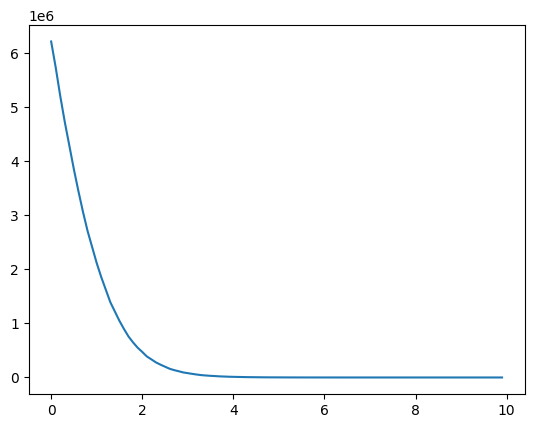

In [156]:
x = np.arange(0,10,0.1)
y = [variance_dict[i]['mean'] for i in np.arange(0,10,0.1)]

plt.plot(x,y)
plt.show()

In [159]:
cross_tab_original = pd.crosstab(private_df['age_cat'], private_df['sex_cat'], margins=False)
type(cross_tab_original)

pandas.core.frame.DataFrame

In [161]:
o = np.array(cross_tab_original)

In [163]:
p = np.array([[1,2],[2,4]])
m = o.size

In [165]:
np.sum((o-p)**2)/m

32909900.75

In [167]:
all_private_datasets = {}
all_results = {}

In [169]:
sensitive_columns = ['age_cat', 'sex_cat']
epsilon_values = [0.01, 0.1, 0.25, 0.5, 1, 2, 3, 5, 10]

all_private_datasets = {}
all_results = {}

for epsilon in epsilon_values:
    private_data, result = apply_ldp(train_data, sensitive_columns, epsilon)
    all_private_datasets[epsilon] = private_data
    all_results[epsilon] = result

    private_data.to_csv(f"private_data_epsilon_{epsilon}.csv", index=False)

    print("\nOriginal Cross-Tabulation:")
    print(result['cross_tab_original'])

    print("\nPrivate Cross-Tabulation:")
    print(result['cross_tab_private'])

    print("\nError Matrix:")
    print(result['error_matrix'])

    print(f"Total Error: {result['total_error']}")


Applying LDP with epsilon = 0.01

Original Cross-Tabulation:
sex_cat     0      1
age_cat             
0        1450   1942
1        4371  10333

Private Cross-Tabulation:
sex_cat_private     0     1
age_cat_private            
0                4579  4500
1                4583  4434

Error Matrix:
sex_cat_private     0     1
age_cat_private            
0                3129  2558
1                 212 -5899
Total Error: 11798
Applying LDP with epsilon = 0.1

Original Cross-Tabulation:
sex_cat     0      1
age_cat             
0        1450   1942
1        4371  10333

Private Cross-Tabulation:
sex_cat_private     0     1
age_cat_private            
0                4507  4485
1                4464  4640

Error Matrix:
sex_cat_private     0     1
age_cat_private            
0                3057  2543
1                  93 -5693
Total Error: 11386
Applying LDP with epsilon = 0.25

Original Cross-Tabulation:
sex_cat     0      1
age_cat             
0        1450   1942
1        4371  10

In [174]:
# for epsilon, private_data in all_private_datasets.items():
#     private_data.to_csv(f"private_data_epsilon_{epsilon}.csv", index=False)
# print("All private datasets have been saved.")


In [176]:
#private_data.to_csv(f"private_data_epsilon_{epsilon}.csv", index=False)


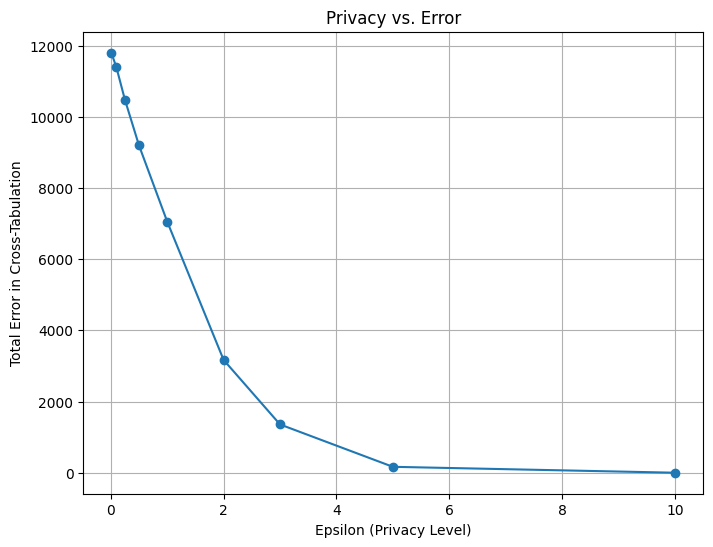

In [178]:
epsilons = list(all_results.keys())
total_errors = [all_results[epsilon]['total_error'] for epsilon in epsilons]

plt.figure(figsize=(8, 6))
plt.plot(epsilons, total_errors, marker='o')
plt.xlabel("Epsilon (Privacy Level)")
plt.ylabel("Total Error in Cross-Tabulation")
plt.title("Privacy vs. Error")
plt.grid()
plt.show()

In [191]:
os.makedirs("../model/lgbm_private", exist_ok=True)

In [193]:
def train_model(train_df,valid_df, epsilon_value):

    train_df = train_df.drop(columns=['age','sex'])
    valid_df = valid_df.drop(columns=['age','sex'])    
                             
    train_df['age_cat'] = apply_randomized_response(train_df['age_cat'], epsilon_value)
    train_df['sex_cat'] = apply_randomized_response(train_df['sex_cat'], epsilon_value)
    
    categorical_cols = [
                    'workclass', 'education', 'marital_status', 'occupation',
                    'relationship', 'race', 'native_country'
                            ]
    numerical_cols = ['fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week','sex_cat','age_cat']
    
    preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numerical_cols),
                ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
            ])


    x_train = train_df.drop(columns=['income'],axis=1)
    y_train = train_df.income.values
    
    x_valid = valid_df.drop(columns=['income'],axis=1)
    y_valid = valid_df.income.values
    
    x_train = preprocessor.fit_transform(x_train)
    x_valid = preprocessor.transform(x_valid)


    clf = LGBMClassifier(objective="binary",verbose=-1)

    clf.fit(x_train,y_train)

    y_train_pred = clf.predict(x_train)
    y_valid_pred = clf.predict(x_valid)
    
    train_precision = precision_score(y_train, y_train_pred, average='macro')  
    train_recall = recall_score(y_train, y_train_pred, average='macro')
    train_f1_score = f1_score(y_train, y_train_pred, average='macro')

    valid_precision = precision_score(y_valid, y_valid_pred, average='macro')  
    valid_recall = recall_score(y_valid, y_valid_pred, average='macro')
    valid_f1_score = f1_score(y_valid, y_valid_pred, average='macro')


    print(f'Train F1 Score:{train_f1_score}, Train Precision:{train_precision}, Train Recall: {train_recall}')
    print(f'Validation F1 Score:{valid_f1_score}, Validation Precision:{valid_precision}, Validation Recall: {valid_recall}')

    joblib.dump(preprocessor,f"../model/lgbm_private/preprocessing_private_{epsilon_value}.pkl")
    joblib.dump(clf,f"../model/lgbm_private/LGBMClassifier_private_{epsilon_value}.pkl")
    

In [196]:
train_model(train_data,val_data,2)

Train F1 Score:0.8360416412871465, Train Precision:0.8595668961094909, Train Recall: 0.8186456064950964
Validation F1 Score:0.8130412183575371, Validation Precision:0.8329097099725151, Validation Recall: 0.7981142483163036


In [198]:
train_model(train_data,val_data,0.5)

Train F1 Score:0.8351033960298484, Train Precision:0.858566219240656, Train Recall: 0.8177588138252885
Validation F1 Score:0.8113517810826254, Validation Precision:0.8323921167663366, Validation Recall: 0.7957821852185021


In [200]:
train_model(train_data,val_data,0.01)

Train F1 Score:0.8380566689600055, Train Precision:0.8620165212008049, Train Recall: 0.8203810986924709
Validation F1 Score:0.8123919515164983, Validation Precision:0.8309744717531822, Validation Recall: 0.7982301094310801


## Model Privacy Assessment

In [206]:
epsilon = 2

In [208]:
selected_processor = joblib.load(f"../model/lgbm_private/preprocessing_private_{epsilon}.pkl")
selected_model = joblib.load(f"../model/lgbm_private/LGBMClassifier_private_{epsilon}.pkl")

----

In [211]:
X_test

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,age_cat,sex_cat
1763,Senior,Private,162034,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,70,United-States,1,1
6705,Senior,Private,245661,HS-grad,9,Separated,Machine-op-inspct,Own-child,White,Female,0,0,40,United-States,1,0
28702,Senior,Private,402998,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,58,United-States,1,1
20146,Senior,Private,142383,Assoc-acdm,12,Never-married,Sales,Not-in-family,Other,Male,0,0,36,United-States,1,1
5918,Senior,Private,211032,Preschool,1,Married-civ-spouse,Farming-fishing,Other-relative,White,Male,41310,0,24,Mexico,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3441,Senior,Private,296125,HS-grad,9,Separated,Priv-house-serv,Unmarried,Black,Female,0,0,30,United-States,1,0
7339,Junior,Private,176486,Assoc-voc,11,Never-married,Adm-clerical,Own-child,White,Female,0,0,36,United-States,0,0
21405,Junior,Private,109667,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,40,United-States,0,1
28513,Senior,Private,197565,Assoc-voc,11,Never-married,Adm-clerical,Own-child,White,Female,0,0,35,United-States,1,0


In [213]:
X_test = test_data.drop(columns=['age','sex','income'])
y_test = test_data.income

In [219]:
y_test

1763     0
6705     0
28702    1
20146    0
5918     0
        ..
3441     0
7339     0
21405    0
28513    0
4191     0
Name: income, Length: 6033, dtype: int64

In [215]:
X_test

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,age_cat,sex_cat
1763,Private,162034,Bachelors,13,Married-civ-spouse,Sales,Husband,White,0,0,70,United-States,1,1
6705,Private,245661,HS-grad,9,Separated,Machine-op-inspct,Own-child,White,0,0,40,United-States,1,0
28702,Private,402998,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,0,0,58,United-States,1,1
20146,Private,142383,Assoc-acdm,12,Never-married,Sales,Not-in-family,Other,0,0,36,United-States,1,1
5918,Private,211032,Preschool,1,Married-civ-spouse,Farming-fishing,Other-relative,White,41310,0,24,Mexico,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3441,Private,296125,HS-grad,9,Separated,Priv-house-serv,Unmarried,Black,0,0,30,United-States,1,0
7339,Private,176486,Assoc-voc,11,Never-married,Adm-clerical,Own-child,White,0,0,36,United-States,0,0
21405,Private,109667,Some-college,10,Never-married,Other-service,Own-child,White,0,0,40,United-States,0,1
28513,Private,197565,Assoc-voc,11,Never-married,Adm-clerical,Own-child,White,0,0,35,United-States,1,0


In [221]:
X_test = selected_processor.transform(X_test)
y_test_prediction = selected_model.predict(X_test)

In [223]:
print(classification_report(y_test,y_test_prediction))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4531
           1       0.76      0.64      0.70      1502

    accuracy                           0.86      6033
   macro avg       0.83      0.79      0.80      6033
weighted avg       0.86      0.86      0.86      6033



In [225]:
test_data['income_pred'] = y_test_prediction